<a href="https://colab.research.google.com/github/rdemarqui/tim_data_academy/blob/main/mistral_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tagging Customer Feedback with LLM

This study aims to explore the advanced LLM tool Mistral 7B to analyze a vast collection of complaints gathered from the website [reclameaqui.com.br](reclameaqui.com.br). Through this analysis, we intend to demonstrate the potential and effectiveness of LLMs in interpreting and handling large-scale user feedback.

## Complaint Dataset

### Load

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sns.set_theme()

In [ ]:
# Loading data
data_url = 'https://raw.githubusercontent.com/rdemarqui/tim_data_academy/main/data/df_validation.xlsx'
data = pd.read_excel(data_url, usecols=['problem', 'description'])
print(data.shape)

(202, 2)


### Clean

In [ ]:
# Remove special characters, extra space and uncase all words
data['description'] = data['description'].astype(str)
data['description'] = data['description'].str.replace(r'<', ' ', regex=True)
data['description'] = data['description'].str.replace(r'>', ' ', regex=True)
data['description'] = data['description'].str.replace(r'#', ' ', regex=True)
data['description'] = data['description'].str.replace(r'\s{2,}', ' ', regex=True)
data['description'] = data['description'].str.lower()

In [ ]:
# Modify mask made by reclame aqui
def remove_mask(text):
  return text.replace("[editado pelo reclame aqui]", "[mask]")

data['description'] = data['description'].apply(remove_mask)

In [ ]:
# Remove description less than 3 characters
data = data[data['description'].str.len() > 3].copy()
df = data.copy()

### Analysis

In [ ]:
# Show each problem category
print(df['problem'].value_counts())

problem
Consumo de crédito                         15
Problema com recarga                       15
Portabilidade                              15
Promoções                                  15
Cancelamento                               15
Instabilidade do sinal                     15
Planos e tarifas                           14
Qualidade da internet                      14
Demora na execução                         14
Cobrança indevida                          14
Mudança de plano                           14
Problemas com o chip                       14
Corte indevido da linha                    14
Mau atendimento do prestador de serviço    14
Name: count, dtype: int64


In [ ]:
# Show words statistics
df['word_count'] = df['description'].str.split().str.len()
df['text_len'] = df['description'].str.len()
print(df['word_count'].describe())

count    202.000000
mean     104.148515
std       73.674811
min        4.000000
25%       48.000000
50%       89.000000
75%      147.500000
max      437.000000
Name: word_count, dtype: float64


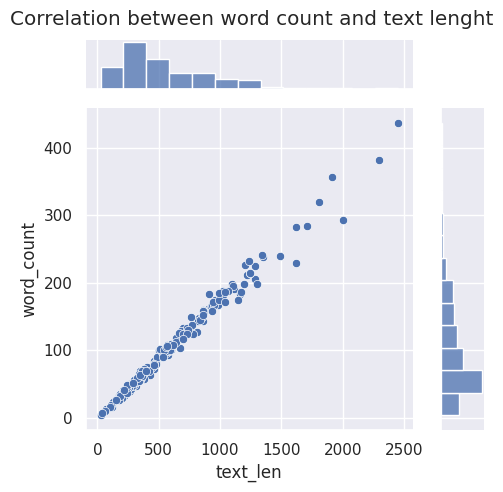

In [ ]:
# Check correlation between word count and text lenght
chart_joint = sns.jointplot(data=df, x="text_len", y="word_count", height=5)
chart_joint.fig.suptitle("Correlation between word count and text lenght")
chart_joint.fig.tight_layout()
chart_joint.fig.subplots_adjust(top=0.92)

In [ ]:
# Check word median per category
print(df.groupby('problem')['word_count'].median())

problem
Cancelamento                               133.0
Cobrança indevida                          157.0
Consumo de crédito                          90.0
Corte indevido da linha                     64.0
Demora na execução                          56.0
Instabilidade do sinal                      53.0
Mau atendimento do prestador de serviço    110.0
Mudança de plano                            99.0
Planos e tarifas                            97.5
Portabilidade                              100.0
Problema com recarga                        54.0
Problemas com o chip                       109.0
Promoções                                   56.0
Qualidade da internet                       60.5
Name: word_count, dtype: float64


## Text Classification

### Load Model

There are several 7B models available as open source, such as Mistral, Falcon, Zephyr, and Openchat. In this study we will use Mistral, but other models can also be tested, just paying attention to adapting the instruction structure.

In [ ]:
import time
from datetime import timedelta, datetime
from google.colab import files
from IPython.display import clear_output

In [ ]:
# Check nvidia CUDA installed
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [ ]:
# Install compatible pytorch
#!pip install torch==2.2.0
#clear_output()

In [ ]:
!pip3 install --upgrade transformers optimum
!pip install auto-gptq
clear_output()

In [ ]:
# Check pytorch + cuda package installed
import torch; print(torch.__version__)

2.6.0+cu124


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

We will load the pre-trained Mistral 7B model, quantized by the user TheBloke and available at https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GPTQ

In [ ]:
# Load LLM and Tokenizer
model_id = "TheBloke/Mistral-7B-Instruct-v0.2-GPTQ"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    trust_remote_code=False,
    revision="main"
)

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:410: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:418: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:461: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
Some weights of the model checkpoint at TheBloke/Mistral-7B-Instruct-v0.2-GPTQ were not used when initializing MistralForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.v_proj.bias', 'model.layers.10.mlp.down_proj.bias', 'model.layers.10.mlp.gate_proj.bias', 'model.layers.10.mlp.up_proj.bias', 'model.layers.10.self_attn.k_proj.bias', 'model.layers.10.self_attn.o_proj.bias', 'model.layers.10.self_attn.q_pr

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [ ]:
# Create a pipeline
generator = pipeline(
    model=model,
    tokenizer=tokenizer,
    task='text-generation',
    max_new_tokens=60,
    temperature=0.05,
    do_sample=True,
    return_full_text = False,
    pad_token_id=tokenizer.eos_token_id
                )

Device set to use cuda:0


### Prompt Engineering

Prompt Guides:
* https://docs.mistral.ai/guides/prompting-capabilities/
* https://www.promptingguide.ai/models/mistral-7b
* https://huggingface.co/docs/transformers/main/tasks/prompting

In [ ]:
# Define tags
tags = ['sinal/conexão de rede', 'cobrança indevida', 'consumo saldo/crédito',
        'plano/benefício', 'cancelamento linha/plano', 'chip/sim card', 'spam',
        'portabilidade', 'recarga/pagamento', 'dificuldade de contato']

# Transform tag list in one string
tags_comma = ", ".join(f"{tag}" for tag in tags)

In [ ]:
# Examples
dialog_dict = {
    "conv1_1t": ["Esse plano é ruim!", "plano/benefício"],
    "conv2_1t": ["Recebo muitas mensagens de propaganda", "spam"]
}

In [ ]:
complaint_text = """
Reclamação: {user_complain}
"""

task = """
Tarefa: Classifique a reclamação. Atenção use apenas as categorias abaixo.
{tags}

Importante, apenas classifique sem explicar!
"""
answer = """
Rótulos:"""

#### Zero-shot

In [ ]:
zero_shot = ('[INST]' + complaint_text
             + task.format(tags=tags_comma)
             + answer + '[/INST]')
print(zero_shot)

[INST]
Reclamação: {user_complain}

Tarefa: Classifique a reclamação. Atenção use apenas as categorias abaixo.
sinal/conexão de rede, cobrança indevida, consumo saldo/crédito, plano/benefício, cancelamento linha/plano, chip/sim card, spam, portabilidade, recarga/pagamento, dificuldade de contato

Importante, apenas classifique sem explicar!

Rótulos:[/INST]


#### Few-shot

In [ ]:
few_examples = """
###
Abaixo alguns exemplos:

Reclamação: {ex1}
Rótulos: {cat1}
Reclamação: {ex2}
Rótulos: {cat2}
###
""".format(ex1=dialog_dict['conv1_1t'][0], cat1=dialog_dict['conv1_1t'][1],
           ex2=dialog_dict['conv2_1t'][0], cat2=dialog_dict['conv2_1t'][1])

In [ ]:
few_shot = (
    '[INST]'
    + complaint_text + task.format(tags=tags_comma)
    + few_examples + answer
    + '[/INST]')

print(few_shot)

[INST]
Reclamação: {user_complain}

Tarefa: Classifique a reclamação. Atenção use apenas as categorias abaixo.
sinal/conexão de rede, cobrança indevida, consumo saldo/crédito, plano/benefício, cancelamento linha/plano, chip/sim card, spam, portabilidade, recarga/pagamento, dificuldade de contato

Importante, apenas classifique sem explicar!

###
Abaixo alguns exemplos:

Reclamação: Esse plano é ruim!
Rótulos: plano/benefício
Reclamação: Recebo muitas mensagens de propaganda
Rótulos: spam
###

Rótulos:[/INST]


#### Multi-turn conversation

In [ ]:
conv = """<s>[INST]
Reclamação: {user_complain}

Tarefa: Classifique a reclamação. Atenção use apenas as categorias abaixo.
{tags}

Importante, apenas classifique sem explicar!

Rótulos:[/INST] {answer}
</s>
"""
conv_1 = conv.format(user_complain=dialog_dict['conv1_1t'][0],
                     tags=tags_comma,
                     answer=dialog_dict['conv1_1t'][1])
conv_2 = conv.format(user_complain=dialog_dict['conv2_1t'][0],
                     tags=tags_comma,
                     answer=dialog_dict['conv2_1t'][1])

In [ ]:
multi_turn = (conv_1 + conv_2 + zero_shot)
print(multi_turn)

<s>[INST]
Reclamação: Esse plano é ruim!

Tarefa: Classifique a reclamação. Atenção use apenas as categorias abaixo.
sinal/conexão de rede, cobrança indevida, consumo saldo/crédito, plano/benefício, cancelamento linha/plano, chip/sim card, spam, portabilidade, recarga/pagamento, dificuldade de contato

Importante, apenas classifique sem explicar!

Rótulos:[/INST] plano/benefício
</s>
<s>[INST]
Reclamação: Recebo muitas mensagens de propaganda

Tarefa: Classifique a reclamação. Atenção use apenas as categorias abaixo.
sinal/conexão de rede, cobrança indevida, consumo saldo/crédito, plano/benefício, cancelamento linha/plano, chip/sim card, spam, portabilidade, recarga/pagamento, dificuldade de contato

Importante, apenas classifique sem explicar!

Rótulos:[/INST] spam
</s>
[INST]
Reclamação: {user_complain}

Tarefa: Classifique a reclamação. Atenção use apenas as categorias abaixo.
sinal/conexão de rede, cobrança indevida, consumo saldo/crédito, plano/benefício, cancelamento linha/plano,

#### Prompt test

In [ ]:
# Print each prompt (check)
prompt_dict = {'zero_shot': zero_shot, 'few_shot': few_shot, 'multi_turn': multi_turn}

In [ ]:
def llm_analysis(prompt, complain):
  response = generator(prompt.format(user_complain=complain))
  llm_classification = response[0]['generated_text'].replace('.', '').lower().split('\n')[0]
  return llm_classification

In [ ]:
def iterate_over_interval(df, column, prompt, limit_char, start_row, end_row, save):
  start_time = time.time()

  for nloop, index in enumerate(range(start_row, end_row)):
    complaint_content = str(df.loc[index, column]).lower()

    # Checkpoint
    if (nloop + 1) % 100 == 0:
      delta_time = str(timedelta(seconds=time.time() - start_time)).split('.')[0]
      print(f"{delta_time} Analysis number {nloop + 1}")

    # Limit text lengh
    if len(complaint_content) > limit_char: complaint_content = complaint_content[:limit_char]+'\n'

    #print(prompt.format(user_complain=complaint_content))  # check prompt

    # Text analysis
    analysis = llm_analysis(prompt, complaint_content)
    df.at[index, 'llm_class'] = analysis

  # Save final result
  delta_time = str(timedelta(seconds=time.time() - start_time)).split('.')[0]
  print(f"{nloop + 1} cases analyzed. Total execution time: {delta_time}")

  if save == True:
    current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
    file_name = 'analise_reclamacao_' + str(start_row) + '_' + str(end_row) + current_datetime + '.xlsx'
    df.to_excel(file_name, index=False)

  return df, file_name if save == True else df

In [ ]:
# Run the example few times to see model consistency
example ="""como sempre, atendimento da claro vago e sem nenhuma solução. estou a uma semana sem serviço na minha linha,
tentando falar na central e só fico presa na ura ou não consigo chegar a lugar algum. detalhe que tudo isso
precisa ser feito de outro celular já que não tenho sinal!!!!!!!!!!!!!não é a primeira vez que fico sem sinal
esse ano pelo chip virtual e que sou impactada em trabalho e já estou nisso a 1 semana. a resposta da central
foi: vá até uma loja física. eu tenho um chip virtual, qual o sentido de ir a uma loja física olhar um chip
virtual que o supervisor que consegui falar nem sabia do que se tratava???? fora que minha [ultima ida a loja
fisica fui cobrada por um chip dependente indevido que colocaram na minha conta e que nunca recebi reembolso.segue
protocolo:*******070quero saber qual o desconto que terei em fatura nesses dias sem serviço e não tenho
disponibilidade para ir a loja física por isso adquiri um chip virtual pela facilidade (que não existe do lado
de vocês) nesse processo.a qualidade do serviço é cada dia pior e eu ainda me pergunto pq sou cliente de vocës.
""".lower()

for prompt in prompt_dict:
  print('\n - ', prompt)
  for i in list(range(1, 4)):
    analysis = llm_analysis(prompt_dict[prompt], example)
    print(analysis)


 -  zero_shot
 sinal/conexão de rede, cobrança indevida
 sinal/conexão de rede, cobrança indevida
 sinal/conexão de rede, cobrança indevida

 -  few_shot
 sinal/conexão de rede, dificuldade de contato


KeyboardInterrupt: 

### Multi-label Evaluation

In this section we will evaluate our prompt. To do that we labaled mannualy the **df_val** dataframe to use as comparision with model output.

There are a few metrics to evaluate multi-label classification, in this work we gonna use `classification_report`from `sklearn`, that is a well known package wich give us manny metrics to analyse. If you you want to know more about it, there's a good article made by Aniruddha Karajgi, on https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea.

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# Creates binary classification columns and sum total classifications
def binary_cols(dataframe, column, tags):
  for tag in tags:
      dataframe[tag] = dataframe[column].apply(lambda x: 1 if tag in x else 0)

  dataframe[column + '_sum'] = dataframe[tags].sum(axis=1)

**Note:** Depending on the amount of data, the classification process can take a few hours. Using the quantized model described above, with zero shot prompt and utilizing the free tier infrastructure of Colab, I noticed that Mistral 7B takes about an hour to classify 2.000 cases.

Colab tends to disconnect due to inactivity. To prevent this, open your browser's inspector, go to the console tab, paste the code below, and press enter.

`function ClickConnect(){
    console.log("Working");
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)`

In [ ]:
# Open validation dataset tagged manually
df_val_url = 'https://raw.githubusercontent.com/rdemarqui/sbrc_2024/main/data/df_validation.xlsx'
df_val_labeled = pd.read_excel(df_val_url)

In [ ]:
# Check each prompt performance
y_expected = df_val_labeled[tags]
score_dict = {}
file_name_dict = {}

for prompt in prompt_dict:
  print("\n- ", prompt)
  temp_df, file_name = iterate_over_interval(df=df, column="description",
                                             prompt=prompt_dict[prompt],
                                             limit_char=2000, start_row=0,
                                             end_row=202, save=True)

  binary_cols(dataframe=temp_df, column='llm_class', tags=tags)

  y_pred = temp_df[tags]

  score_dict[prompt] = classification_report(y_expected, y_pred,
                                             output_dict=True,
                                             target_names=tags)
  file_name_dict[prompt] = file_name


-  zero_shot
0:01:46 Analysis number 100
0:03:27 Analysis number 200
202 cases analyzed. Total execution time: 0:03:31

-  few_shot
0:02:44 Analysis number 100
0:05:02 Analysis number 200
202 cases analyzed. Total execution time: 0:05:05

-  multi_turn
0:04:17 Analysis number 100
0:08:36 Analysis number 200
202 cases analyzed. Total execution time: 0:08:45


There's some ways to agregate metrics such as `micro average`, `macro avarage`, `weighted average` and `samples average`. In this study we gonna use `samples avg`, wich was specifically designed for multilabel scenarios. It calculates metrics like precision, recall, and F1-score for each instance individually and averages them, thus effectively evaluating the model's performance on each sample by considering all its labels, making it particularly useful for assessing how well the model predicts the label set for each individual sample.

In [ ]:
# Create score comparison table
df_score_comparison = pd.DataFrame()

for prompt in prompt_dict:
  score_temp = score_dict[prompt]['samples avg']
  df_temp = pd.DataFrame(score_temp, index=[prompt])
  df_score_comparison = pd.concat([df_score_comparison, df_temp])

round(df_score_comparison, 4)

,precision,recall,f1-score,support
zero_shot,0.6423,0.7066,0.6350,301
few_shot,0.6535,0.7092,0.6416,301
multi_turn,0.6927,0.7124,0.6682,301


Remembering that:

* **Precision:** It is the proportion of positive identifications that were actually correct. A low precision indicates that there were **too many False Positives (FP)**, meaning that the model predicted many instances as positive that were actually negative.

 $\frac{\text{True Positive}}{\text{Total Predicted Positive}} = \frac{\text{True Positive (TP)}}{\text{True Positive (TP)} + \text{False Positive (FP)}}$

* **Recall:** It is the proportion of actual positives that were identified correctly. A low recall indicates that there were **too many False Negatives (FN)**, meaning that the model failed to identify many actual positive instances.

 $\frac{\text{True Positive}}{\text{Total Actual Positive}} = \frac{\text{True Positive (TP)}}{\text{True Positive (TP)} + \text{False Negative (FN)}}$

* **F1 Score:** Is the harmonic mean of the precision and recall, bringing a good balance between both.

 ${\text{F1}} = 2* \frac{\text{Precision * Recall}}{\text{Precision + Recall}}$

In this study we will use the prompt that achived the max F1 score, that represents a good balance between precision and recall.

## Results

In [ ]:
max_score_prompt = df_score_comparison['f1-score'].idxmax()
print(f"The max score obtained was achived by '{max_score_prompt}' prompt.")

The max score obtained was achived by 'multi_turn' prompt.


In [ ]:
# Check detailed score from choosen prompt
round(pd.DataFrame(score_dict[max_score_prompt]).transpose(), 4)

,precision,recall,f1-score,support
sinal/conexão de rede,0.9524,0.5882,0.7273,34.0
cobrança indevida,0.6800,0.7556,0.7158,45.0
consumo saldo/crédito,0.5882,0.6250,0.6061,16.0
plano/benefício,0.5263,0.5000,0.5128,40.0
cancelamento linha/plano,0.5490,0.6667,0.6022,42.0
chip/sim card,0.8500,0.5484,0.6667,31.0
spam,0.8333,1.0000,0.9091,10.0
portabilidade,0.6429,0.8182,0.7200,22.0
recarga/pagamento,0.5094,0.8182,0.6279,33.0
dificuldade de contato,0.4571,0.5714,0.5079,28.0


---

In [ ]:
report = classification_report(y_expected, y_pred, target_names=tags)
print(report)

                          precision    recall  f1-score   support

   sinal/conexão de rede       0.95      0.59      0.73        34
       cobrança indevida       0.68      0.76      0.72        45
   consumo saldo/crédito       0.59      0.62      0.61        16
         plano/benefício       0.53      0.50      0.51        40
cancelamento linha/plano       0.55      0.67      0.60        42
           chip/sim card       0.85      0.55      0.67        31
                    spam       0.83      1.00      0.91        10
           portabilidade       0.64      0.82      0.72        22
       recarga/pagamento       0.51      0.82      0.63        33
  dificuldade de contato       0.46      0.57      0.51        28

               micro avg       0.62      0.66      0.64       301
               macro avg       0.66      0.69      0.66       301
            weighted avg       0.65      0.66      0.64       301
             samples avg       0.69      0.71      0.67       301

